In [1]:
import cv2
import mediapipe as mp
import csv
import copy
import itertools
import string
import os
import pandas as pd
from tqdm import tqdm  # Progress bar

# Initialize MediaPipe Hands
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Define dataset path (Fix Windows path issue)
dataset_path = r"C:\Users\dell\Downloads\dataset\data"
csv_path = os.path.join(dataset_path, "keypoints.csv")

# Function to extract hand keypoints
def calc_landmark_list(image, landmarks):
    image_height, image_width = image.shape[:2]
    landmark_point = []
    for landmark in landmarks.landmark:
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append([landmark_x, landmark_y])
    return landmark_point

# Function to normalize keypoints
def pre_process_landmark(landmark_list):
    temp_landmarks = copy.deepcopy(landmark_list)
    base_x, base_y = temp_landmarks[0]

    for i in range(len(temp_landmarks)):
        temp_landmarks[i][0] -= base_x
        temp_landmarks[i][1] -= base_y

    temp_landmarks = list(itertools.chain.from_iterable(temp_landmarks))
    max_value = max(map(abs, temp_landmarks)) if temp_landmarks else 1
    temp_landmarks = [n / max_value for n in temp_landmarks]

    return temp_landmarks

# Function to save keypoints to CSV
def logging_csv(letter, landmark_list, csv_path):
    with open(csv_path, 'a', newline="") as f:
        writer = csv.writer(f)
        writer.writerow([letter, *landmark_list])

# Get list of image files dynamically
alphabet = list(string.ascii_uppercase) + [str(i) for i in range(1, 10)]
image_files = []

for letter in alphabet:
    folder_path = os.path.join(dataset_path, letter)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith((".jpg", ".png")):  # Support multiple formats
                file_path = os.path.join(folder_path, filename)
                image_files.append((file_path, letter))

# Process images
no_hand_count = 0  # Track images with no detected hands

with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    for file_path, label in tqdm(image_files, desc="Processing Images"):
        image = cv2.imread(file_path)
        if image is None:
            continue  # Skip missing images

        image = cv2.flip(image, 1)  # Flip for correct handedness
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmark_list = calc_landmark_list(image, hand_landmarks)
                pre_processed_landmark_list = pre_process_landmark(landmark_list)
                logging_csv(label, pre_processed_landmark_list, csv_path)
        else:
            no_hand_count += 1  # Count failed detections

print(f"⚠️ Skipped {no_hand_count} images due to no hands detected.")

# Verify CSV
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(" CSV loaded successfully!")
    print(" First 5 rows:\n", df.head())
    print(" Column Names:", df.columns)
else:
    print(" CSV file not found!")


KeyboardInterrupt: 

C:\Users\dell\AppData\Local\Temp\ipykernel_8904\2782276405.py:19: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, header=None)


Epoch 1/50


289/289 [==============================] - 17s 45ms/step - loss: 1.1480 - accuracy: 0.6376 - val_loss: 0.1126 - val_accuracy: 0.9713
Epoch 2/50
289/289 [==============================] - 15s 51ms/step - loss: 0.2000 - accuracy: 0.9329 - val_loss: 0.0559 - val_accuracy: 0.9799
Epoch 3/50
289/289 [==============================] - 14s 49ms/step - loss: 0.1204 - accuracy: 0.9599 - val_loss: 0.0409 - val_accuracy: 0.9857
Epoch 4/50
289/289 [==============================] - 12s 43ms/step - loss: 0.0915 - accuracy: 0.9709 - val_loss: 0.0343 - val_accuracy: 0.9897
Epoch 5/50
289/289 [==============================] - 13s 46ms/step - loss: 0.0769 - accuracy: 0.9747 - val_loss: 0.0312 - val_accuracy: 0.9867
Epoch 6/50
289/289 [==============================] - 12s 43ms/step - loss: 0.0691 - accuracy: 0.9777 - val_loss: 0.0259 - val_accuracy: 0.9914
Epoch 7/50
289/289 [==============================] - 13s 44ms/step - loss: 0.0590 - accuracy: 0.9810 - val_loss: 0.0281 - val_accurac

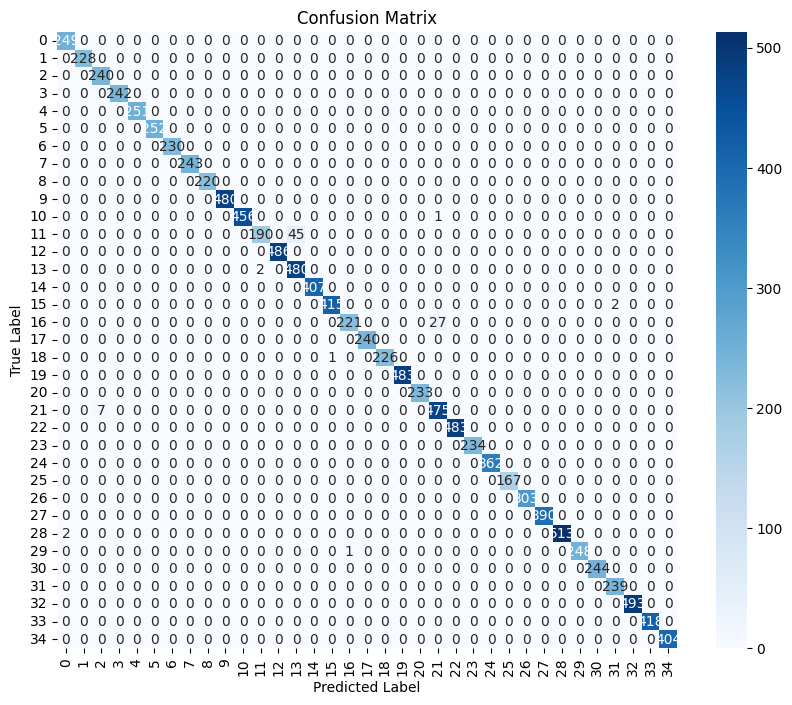

Model saved at: C:\Users\dell\Downloads\dataset\data\model.keras


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.callbacks import EarlyStopping

# Define dataset path
dataset_path = r"C:\Users\dell\Downloads\dataset\data"
file_path = os.path.join(dataset_path, "keypoints.csv")

# Load dataset
data = pd.read_csv(file_path, header=None)

# Convert labels to string type
data[0] = data[0].astype(str)

# Extract features (X) and labels (y)
X = data.iloc[:, 1:]  # All columns except the first (keypoints)
y = LabelEncoder().fit_transform(data[0])  # Encode labels to integers

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Early Stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Define the model
model = keras.Sequential([
    layers.Dense(1470, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(832, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(428, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(264, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')  # 35 classes
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[es])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

# Predict and compute performance metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute metrics
acc = accuracy_score(y_test, y_pred_classes)
prec = precision_score(y_test, y_pred_classes, average='macro')
rec = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

# Print evaluation metrics
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Define model save path
model_save_path = os.path.join(dataset_path, "model.keras")

# Save the trained model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


In [2]:
import pickle
import json

# Paths
label_encoder_path = r"C:\Users\dell\Downloads\dataset\data\label_encoder.pkl"
label_map_path = r"C:\Users\dell\Downloads\dataset\data\label_map.json"

# Load the Label Encoder
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# Extract class names
class_names = label_encoder.classes_.tolist()  # Convert to list

# Save class names as JSON
label_map = {i: class_name for i, class_name in enumerate(class_names)}
with open(label_map_path, "w") as f:
    json.dump(label_map, f, indent=4)

print(" Label Encoder converted to label_map.json!")
print("Class Labels:", class_names)


 Label Encoder converted to label_map.json!
Class Labels: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
